## Fix later!!
## ENCM 509 Final Project (Face Detection and Recognition using OpenCV)
## Group 7
## Members: Ahmed Anwar, Ali Mekawy, Mohamed Mahmoud

In [436]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
import numpy as np
from sklearn.utils import shuffle
import os
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import shutil
from sklearn.metrics import roc_curve, det_curve

In [437]:
# Define source directory and target directories
src_dir = 'ATT_dataset'
train_dir = 'train_dataset'
test_dir = 'test_dataset'

# Create target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of all subdirectories
subdirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

# Loop over each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(src_dir, subdir)
    images = os.listdir(subdir_path)
    
    # Shuffle the list of images
    np.random.shuffle(images)
    
    # Split the list of images into training and testing sets
    train_images = images[:int(0.7*len(images))]
    test_images = images[int(0.8*len(images)):]

    # Create corresponding subdirectories in the target directories
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
    
    # Copy the training images to the training directory
    for image in train_images:
        shutil.copy(os.path.join(subdir_path, image), os.path.join(train_dir, subdir, image))
    
    # Copy the testing images to the testing directory
    for image in test_images:
        shutil.copy(os.path.join(subdir_path, image), os.path.join(test_dir, subdir, image))

In [226]:
DATASET_PATH = 'ATT_dataset'
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
IMAGE_SIZE = 128

In [139]:
if not os.path.exists(DATASET_PATH):
    print('Dataset not found!')
    exit(1)

# Load dataset
classes = os.listdir(DATASET_PATH)
print('Found {} classes: {}'.format(len(classes), classes))

Found 40 classes: ['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


In [362]:
images = []
labels = []
class_index = 0
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        # image = image.flatten()
        # image = cv2.resize(image, (1, len(image)* len(image[0])))
        # image = np.float32(np.array(image) / 255.0)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        labels.append(class_index)
    class_index += 1
images = np.array(images)
labels = np.array(labels)
print('Loaded {} images.'.format(len(images)))

Loaded 400 images.


In [328]:
print(images.shape)

(400, 10304, 1, 3)


In [438]:
import cv2
import numpy as np
from glob import glob

def get_data(path):
    
    paths = glob(path, recursive=True)
    data = []
    label = []

    for path in paths:
        img = cv2.imread(path, 0)
        subject_label = path[path.rfind('s')+1:path.rfind('\\')]

        img = cv2.resize(img, (1, len(img)* len(img[0])))
        img = np.float32(np.array(img) / 255.0)

        # do lbp featyre excraction
        # lbp = local_binary_pattern(img, 12, 3)
        # (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
        

        # visualise image
        # plt.imshow(img, cmap='gray')

        data.append(img)
        label.append(int(subject_label))

    return np.array(data)[:,:,0], np.array(label)

In [ ]:
train_path = r'train_dataset\\**\\*.pgm'
test_path = r'test_dataset\\**\\*.pgm'


data, labe = get_data(train_path)
test_data, test_label = get_data(test_path)

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

data = data.astype(np.float32)
svm.train(data, cv2.ml.ROW_SAMPLE, labe)
test_data = test_data.astype(np.float32)
prediction = svm.predict(test_data)[1]

result = prediction[:,0] == test_label
accuracy = np.mean(result)
print('Accuracy: ', accuracy)

Accuracy:  0.8416666666666667


In [456]:
mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 512), learning_rate_init=0.0001, random_state= 1, max_iter = 200)

data, labe = get_data(train_path)
test_data, test_label = get_data(test_path)

mlp.fit(data, labe)

probability_matrix = mlp.predict_proba(test_data)
prediction = mlp.predict(test_data)
accuracy = np.mean(prediction == test_label)
print('Accuracy: ', accuracy)

Accuracy:  0.7583333333333333


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0.5, 1.0, 'DET Curve')

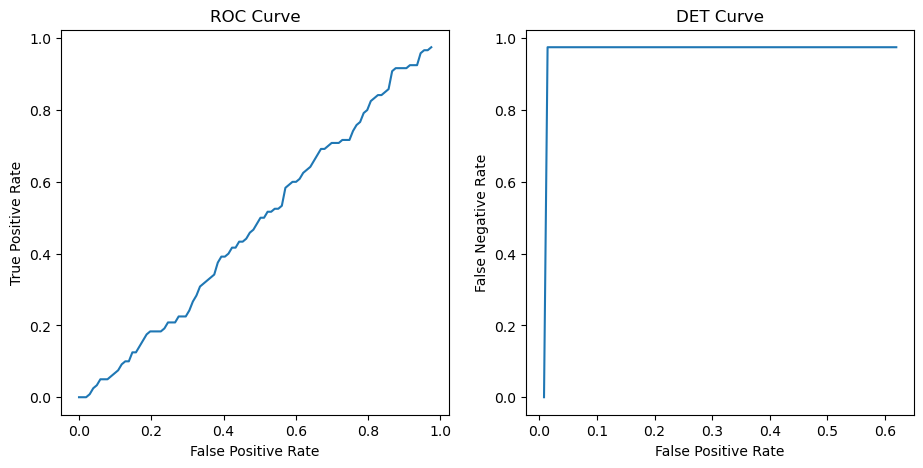

In [457]:
roc_fpr = np.zeros((40, 100))
roc_tpr = np.zeros((40, 100))

det_fpr = np.zeros((40, 100))
det_fnr = np.zeros((40, 100))

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for i in range(1,40):
    fpr, tpr, _ = roc_curve(test_label == i, probability_matrix[:, i])

    roc_fpr[i] = np.linspace(min(fpr), max(fpr), 100)
    roc_tpr[i] = np.interp(roc_fpr[i], fpr, tpr)

    fpr, fnr, _ = det_curve(test_label[:] == i, probability_matrix[:, i])
    det_fpr[i] = np.linspace(min(fpr), max(fpr), 100)
    det_fnr[i] = np.interp(det_fpr[i], fpr, fnr)

roc_mid_fpr = np.mean(roc_fpr, axis=0)
roc_mid_tpr = np.mean(roc_tpr, axis=0)
ax_roc.plot(roc_mid_fpr, roc_mid_tpr, label='ROC curve')

det_mid_fpr = np.mean(det_fpr, axis=0)
det_mid_fnr = np.mean(det_fnr, axis=0)
ax_det.plot(det_mid_fpr, det_mid_fnr, label='DET curve')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')

ax_det.set_xlabel('False Positive Rate')
ax_det.set_ylabel('False Negative Rate')
ax_det.set_title('DET Curve')




In [454]:
## plot roc curve
fpr, tpr, _ = roc_curve(test_label, prediction)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


ValueError: multiclass format is not supported

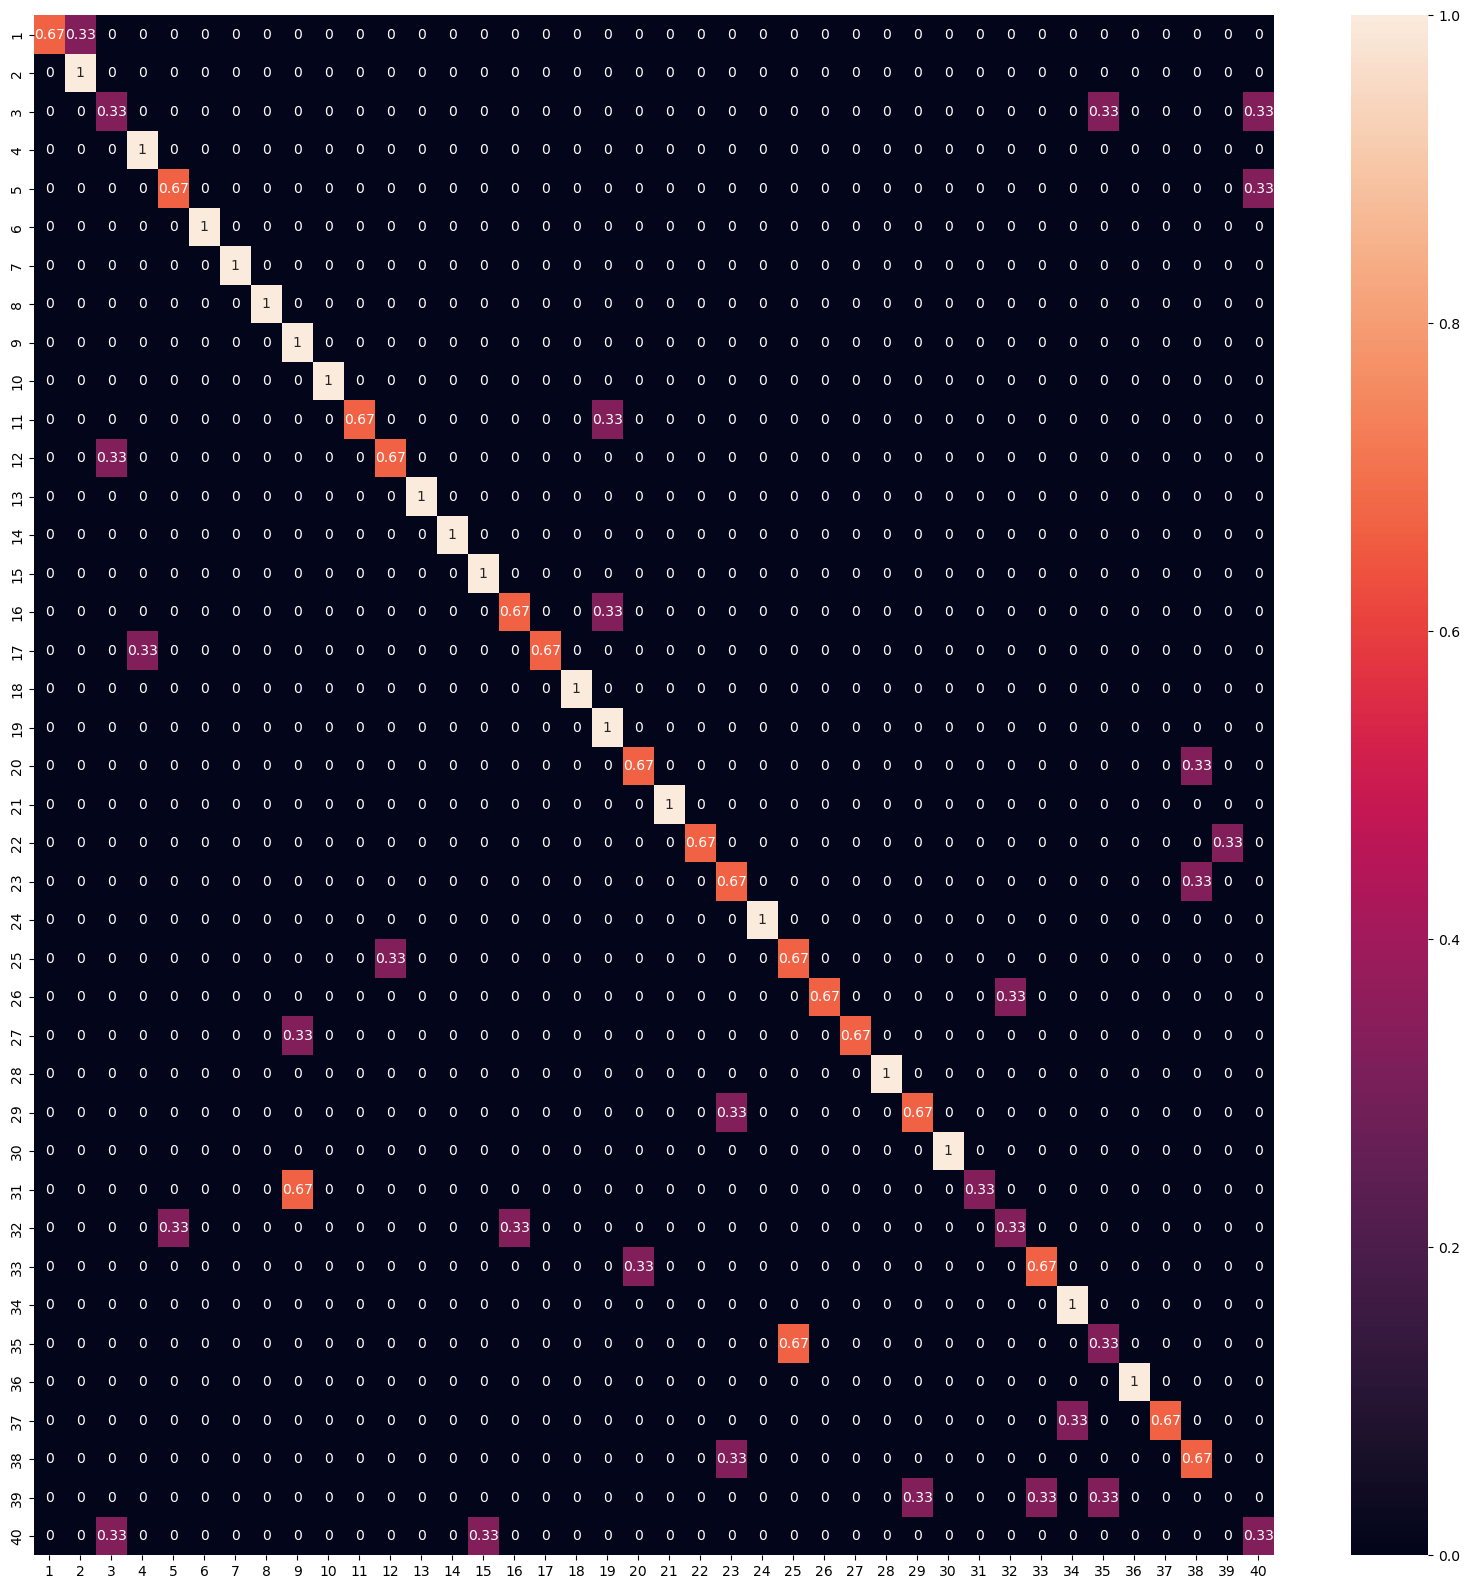

In [444]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(test_label, prediction)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)
conf_matrix = np.round(conf_matrix, 2)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(1, 41)],
                  columns = [i for i in range(1, 41)])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.show()


In [365]:
# Shuffle the dataset with scikit-learn
images, labels = shuffle(images, labels, random_state=0)
print('Shuffled dataset.')

Shuffled dataset.


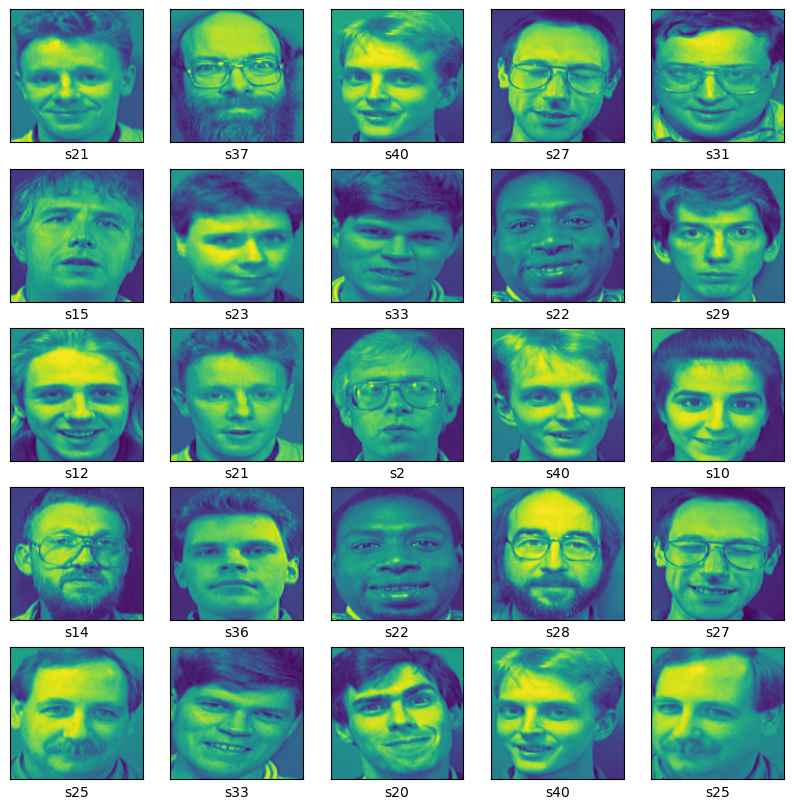

In [366]:
# Plot 25 random images from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(classes[labels[i]])

plt.show()

In [217]:
x_train, x, y_train, y = train_test_split(images, labels, test_size=TEST_SPLIT + VALIDATION_SPLIT, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=TEST_SPLIT / (TEST_SPLIT + VALIDATION_SPLIT),
                                                random_state=0)

In [369]:
path = 'ATT_dataset/s1/1.pgm'
img = cv2.imread(path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(img)

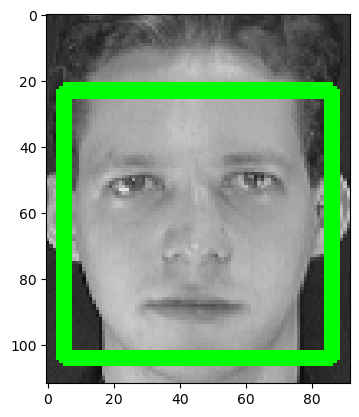

In [459]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

face_box = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

for (x, y, w, h) in face_box:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Check if extracting the face makes a difference on the accuracy and stuff.

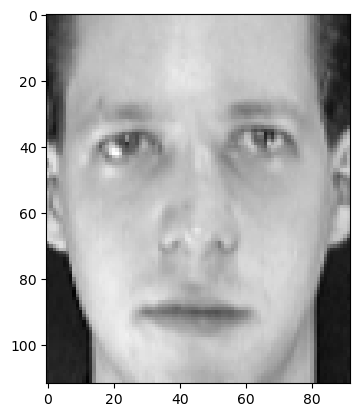

In [461]:
# extract the face from the image
face = gray[y:y+h, x:x+w]
plt.imshow(face, cmap='gray')

# resize to original size
face = cv2.resize(face, (92, 112))
plt.imshow(face, cmap='gray')


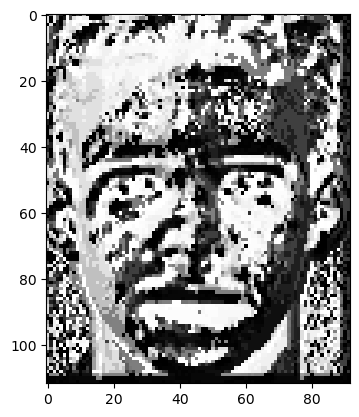

In [357]:
img = cv2.imread('ATT_dataset/s1/1.pgm', cv2.IMREAD_GRAYSCALE)

lbp = local_binary_pattern(img, 12, 3)

plt.imshow(lbp, cmap='gray')

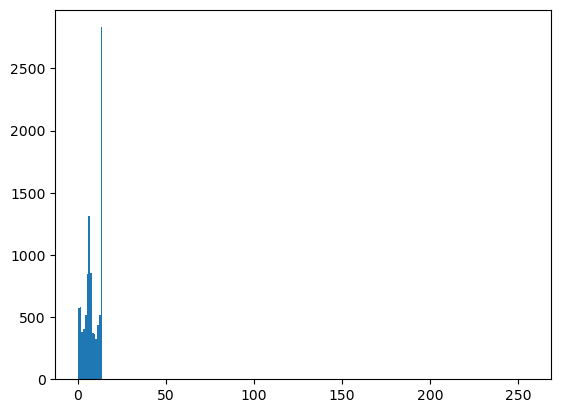

(array([ 576.,  582.,  384.,  404.,  514.,  850., 1310.,  851.,  371.,
        362.,  320.,  433.,  516., 2831.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.

In [130]:
# Get the feature histogram
vector = plt.hist(lbp.ravel(), bins=256, range=(0, 256))
plt.show()
# print(vector)

